<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/BN_math_vs_english_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import listdir
from os.path import isfile, join
import re
import string
from PIL import Image
from scipy.io import wavfile
from scipy import ndimage
import imageio

import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def loadImage(filepath):
  # img = load_img(filepath, target_size=(ch, cw), grayscale=True)
  img = load_img(filepath, grayscale=True)
  img = img_to_array(img)
  #img = img.reshape(1, 42, 42, 3)
  #img = img.reshape(32, 125, 3)
  img = img.astype('float32')
  # img = img / 255.0
  return img

# plt.imshow(loadImage('./word.png')[:,:,0], cmap='gray')

### Text vs Math Classification

In [3]:
# !pip install 'h5py==2.10.0' --force-reinstall

#### English pictures

In [4]:
!pip install trdg
!trdg -c 10000 -w 5 -f 64 --length 1

  0% 0/10000 [00:00<?, ?it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/trdg/data_generator.py", line 22, in generate_from_tuple
    cls.generate(*t)
  File "/usr/local/lib/python3.7/dist-packages/trdg/data_generator.py", line 83, in generate
    stroke_fill,
  File "/usr/local/lib/python3.7/dist-packages/trdg/computer_text_generator.py", line 46, in generate
    stroke_fill,
  File "/usr/local/lib/python3.7/dist-packages/trdg/computer_text_generator.py", line 88, in _generate_horizontal_text
    space_width = int(get_text_width(image_font, " ") * space_width)
  File "/usr/local/lib/python3.7/dist-packages/trdg/utils.py", line 116, in get_text_width
    return round(image_font.getlength(text))
AttributeError: 'FreeTypeFont' object has no attribute 'getlength'
"""

The above exception was the 

#### Math Pictures

In [5]:
# # Get features
!gdown https://drive.google.com/uc?id=176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
!unzip formulae.zip

# # Get labels
!gdown https://drive.google.com/uc?id=1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D

Streaming output truncated to the last 5000 lines.
 extracting: test/0193073.png        
 extracting: test/0193087.png        
 extracting: test/0193101.png        
 extracting: test/0193103.png        
 extracting: test/0193115.png        
 extracting: test/0193124.png        
 extracting: test/0193133.png        
 extracting: test/0193147.png        
 extracting: test/0193150.png        
 extracting: test/0193156.png        
 extracting: test/0193157.png        
 extracting: test/0193172.png        
 extracting: test/0193174.png        
 extracting: test/0193186.png        
 extracting: test/0193209.png        
 extracting: test/0193211.png        
 extracting: test/0193212.png        
 extracting: test/0193228.png        
 extracting: test/0193235.png        
 extracting: test/0193243.png        
 extracting: test/0193246.png        
  inflating: test/0193260.png        
 extracting: test/0193267.png        
 extracting: test/0193274.png        
 extracting: test/0193275.png        

In [6]:
!mkdir './binary_classification_data'
!cp -r './train' './binary_classification_data'
!mv './binary_classification_data/train' './binary_classification_data/math'

!cp -r './out' './binary_classification_data'
!mv './binary_classification_data/out' './binary_classification_data/english'

In [7]:
!rm -r './binary_classification_data/english/out'
!rm -r './binary_classification_data/out'
!rm -r './binary_classification_data/train'
!rm -r './binary_classification_data/math/train'

rm: cannot remove './binary_classification_data/english/out': No such file or directory
rm: cannot remove './binary_classification_data/out': No such file or directory
rm: cannot remove './binary_classification_data/train': No such file or directory
rm: cannot remove './binary_classification_data/math/train': No such file or directory


In [8]:
!find './binary_classification_data/english' -type f -name "*.jpg" -printf x | wc -c

0


In [9]:
!ls './binary_classification_data/english' | wc -l

0


In [10]:
!if pngcheck "$1" > './binary_classification_data/math' 2>&1 then echo things went ok else echo things went bad fi


/bin/bash: -c: line 1: syntax error: unexpected end of file


### Binary Classification Setup

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

from sklearn.model_selection import train_test_split

import re
np.random.seed(42)
tf.random.set_seed(42)

In [12]:

AUTOTUNE = tf.data.AUTOTUNE

# # Mapping characters to integers.
# char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# # Mapping integers back to original characters.
# num_to_char = StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

In [13]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [14]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32
max_len = 2


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    return (image, tf.convert_to_tensor(label))

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


### Binary Classification Data Preparation

In [15]:
import os
from PIL import Image


data_F = []
data_L = []

math_images_path = './binary_classification_data/math'

n_images = len( os.listdir(math_images_path))

for fi in os.listdir(math_images_path)[0:10000]:
    
    math_img = f'./binary_classification_data/math/{fi}'

    # img = Image.open(math_img)
    try:
        Image.open(math_img).verify()
        data_F.append(math_img)
        # data_L.append('math')
        data_L.append(0)
        # print('Valid image')
    except Exception:
        # print('file is',  image)
        # print('Invalid image')
        os.remove(math_img) 

print('math size', len(data_L))

math size 9990


In [16]:
english_images_path = './binary_classification_data/english'

n_images = len( os.listdir(english_images_path))

for fi in os.listdir(english_images_path)[0:6000]:
    data_F.append(f'./binary_classification_data/english/{fi}')
    # data_L.append('english')
    data_L.append(1)

print('english size', n_images)

english size 0


In [17]:
train_img_paths, validation_img_paths, train_labels_cleaned, validation_labels_cleaned = train_test_split(data_F, data_L, test_size=0.5, random_state=0)
validation_img_paths, test_img_paths, validation_labels_cleaned, test_labels_cleaned = train_test_split(validation_img_paths, validation_labels_cleaned, test_size=0.5, random_state=1)

In [18]:
len(train_img_paths), len(validation_img_paths), len(test_img_paths)

(4995, 2497, 2498)

In [19]:
len(train_labels_cleaned), len(validation_labels_cleaned), len(test_labels_cleaned)

(4995, 2497, 2498)

In [20]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [21]:
#print(train_img_paths[0:45])
print(train_labels_cleaned[200:300])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Preview Images

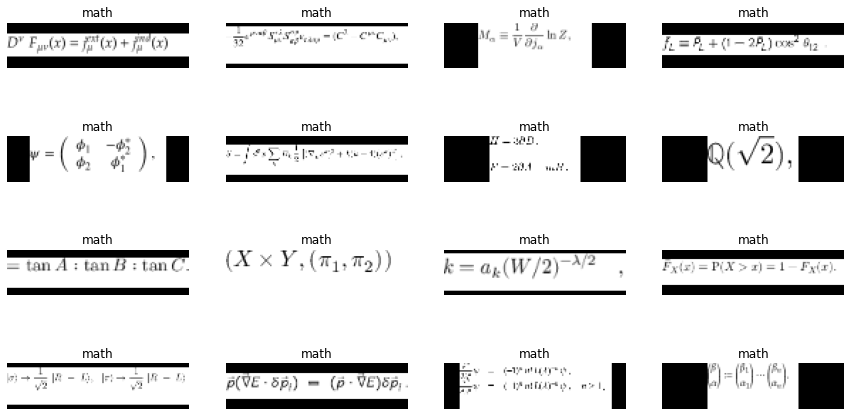

In [22]:
for data in train_ds.take(1):
    # images, labels = data["image"], data["label"]
    images, labels = data[0], data[1]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):

        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        if (label == 0):
          label = 'math'
        else:
          label = 'english'
        #indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        #label = tf.strings.reduce_join(num_to_char(indices))
        #label = label.numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

### Binary Image Classification

In [23]:
# Reference:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb

In [24]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

In [29]:
num_classes = len([0,1])

model = Sequential([
  # layers.Input(),
  layers.Input(shape=(image_width, image_height, 1), name="image"),
  layers.Input(name="label", shape=(None,)),
  layers.Conv2D(
      32, 
      3, 
      padding='same', 
      activation='relu', 
    ),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 label (InputLayer)          multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 32, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 8, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 8, 128)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
79/79 [==============================] - 46s 573ms/step - loss: 5.2648e-04 - accuracy: 0.9876 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
